## Homework 4 

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [129]:
df = pd.read_csv('bank-full.csv', sep=";")
df.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [144]:
features = [   
    "age",
    "job",
    "marital",
    "education",
    "balance",
    "housing",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "y"
]

# df = df[features].copy()
df = df[features]

In [145]:
df

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [146]:
df_full_train, df_test = train_test_split(df, test_size=0.2 , random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- **`duration`**
- `previous`

In [147]:
categorical_features = list(df.dtypes[df.dtypes == 'object'].index)
numerical_features = [x for x in df.columns.tolist() if x not in categorical_features and x != 'default']


In [148]:
scores = []

for var in numerical_features:
    auc = roc_auc_score(y_train, df_train[var])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
    
    print('%s, %.3f' % (var, auc))
    scores.append((var, auc))

age, 0.512
balance, 0.589
day, 0.526
duration, 0.815
campaign, 0.571
pdays, 0.590
previous, 0.599


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [149]:
def train(df, y_train):
    dicts = df.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model 

In [150]:
dv, model = train(df_train, y_train)

In [151]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X_val = dv.transform(dicts)
    y_pred = model.predict_proba(X_val)[:, 1]
    
    return y_pred

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- **0.89**
- 0.99

In [152]:
y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)

round(auc, 3)

np.float64(0.9)

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* **0.265**
* 0.465
* 0.665
* 0.865

In [153]:
def precision_and_recall(y_val, y_pred):
    thresholds = np.linspace(0, 1, 100)
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 'yes')
        actual_negative = (y_val == 'no')

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        
        scores.append((t, tp, fp, tn, fn, p, r))
        
    columns = ['threshold','tp', 'fp', 'tn', 'fn' ,'precision', 'recall']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores 

In [154]:
df_scores = precision_and_recall(y_val, y_pred)

/tmp/ipykernel_35168/1274632664.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


In [155]:
df_scores[:12]

,threshold,tp,fp,tn,fn,precision,recall
0,0.000000,1098,7944,0,0,0.121433,1.000000
1,0.010101,1094,6989,955,4,0.135346,0.996357
2,0.020202,1093,5771,2173,5,0.159237,0.995446
3,0.030303,1087,4713,3231,11,0.187414,0.989982
4,0.040404,1066,3773,4171,32,0.220293,0.970856
5,0.050505,1046,3038,4906,52,0.256121,0.952641
6,0.060606,1020,2477,5467,78,0.291679,0.928962
7,0.070707,991,2118,5826,107,0.318752,0.902550
8,0.080808,969,1840,6104,129,0.344963,0.882514
9,0.090909,943,1619,6325,155,0.368072,0.858834


At which threshold precision and recall curves intersect?

* **0.265**
* 0.465
* 0.665
* 0.865

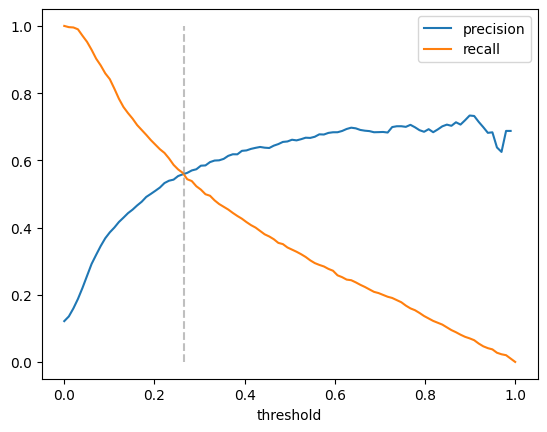

In [156]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision' )
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.vlines(0.265, 0, 1, color="grey", linestyle="--", alpha=0.5)

plt.xlabel('threshold')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [157]:
def f1_score(y_val, y_pred):
    thresholds = np.linspace(0.0, 1.0, 100)
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 'yes')
        actual_negative = (y_val == 'no')

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = false_negative = (predict_negative & actual_positive).sum()
        
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        
        f1_score = 2 * (p * r) / (p + r)
        
        scores.append((t, tp, fp, tn, fn, p, r, f1_score))
        # scores.append((t, f1_score))

    columns = ['threshold','tp', 'fp', 'tn', 'fn' ,'precision', 'recall', 'f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)
        
    return df_scores 

In [158]:
f1_scores = f1_score(y_val, y_pred)
max_idx = f1_scores['f1_score'].idxmax()
f1_scores.iloc[max_idx]

/tmp/ipykernel_35168/3863805797.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


threshold       0.222222
tp            683.000000
fp            600.000000
tn           7344.000000
fn            415.000000
precision       0.532346
recall          0.622040
f1_score        0.573709
Name: 22, dtype: float64

At which threshold F1 is maximal?

- 0.02
- **0.22**
- 0.42
- 0.62

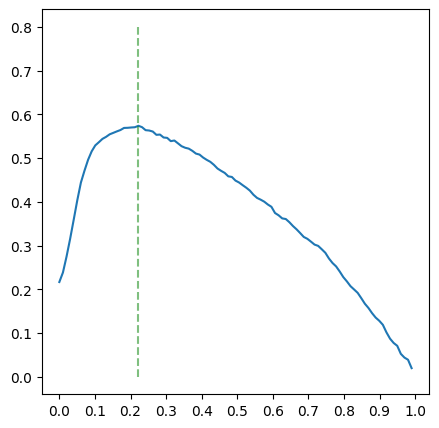

In [159]:
plt.figure(figsize=(5, 5))
plt.plot(f1_scores.threshold, f1_scores.f1_score)

plt.vlines(0.22, 0, 0.8, color='green', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

In [160]:
columns = list(df.columns)
columns.remove('y')
columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

In [161]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [162]:
def train(df, y_train, C=1.0):
    dicts = df[columns].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')
    X = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

How large is standard deviation of the scores across different folds?

- 0.0001
- **0.006**
- 0.06
- 0.26

In [163]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.y.values
    y_val = df_val.y.values
    
    df, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [165]:
def train_C(df, y_train, C):
    dicts = df[columns].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- **1**

In [168]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.y.values
        y_val = df_val.y.values
        
        dv, model = train_C(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%5s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

    

C=1e-06, 0.701 +- 0.009
C=0.001, 0.861 +- 0.007
C=    1, 0.906 +- 0.006
